In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
print(X_motion_CoM_acceleration.shape)
print(Y_motion_CoM_acceleration.shape)

(16930, 31)
(16930, 3)


In [6]:
X_motion_CoM_acceleration[0]

array([0.1, 0.0, 0.0, 0.1, 0.0, 0.0, 0.053033745204898675,
       -0.009420085112190425, -0.02243048986944724, -0.004485537134058458,
       0.22756822407245636, 0.12994003295898438, -0.3845590054988861,
       0.25123128294944763, -0.13026568293571472, -0.38243401050567627,
       -0.2482573390007019, 0.12570568919181824, -0.38843366503715515,
       -0.271675705909729, -0.1239875927567482, -0.3874764144420624,
       0.029258251190185547, 0.0129020931199193, 0.014509100466966629,
       0.017187340185046196, 0.0881090662463693, -0.009770656027082285,
       -0.003868148497500419, True, False], dtype=object)

In [7]:
Y_motion_CoM_acceleration[0]

array([0.026316988999905352, -0.0029183630940723894,
       0.0023450366363710895], dtype=object)

# Multivariate Linear Regression (CoM Prediction)

In [8]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [9]:
idx_fr_rl_swinging = np.where(X_motion_CoM_acceleration[:, -1] == 1)[0]
X_motion_CoM_acceleration_FR_RL = X_motion_CoM_acceleration[idx_fr_rl_swinging]
Y_motion_CoM_acceleration_FR_RL = Y_motion_CoM_acceleration[idx_fr_rl_swinging]
print(X_motion_CoM_acceleration_FR_RL.shape)
print(Y_motion_CoM_acceleration_FR_RL.shape)

(8464, 31)
(8464, 3)


## Predict CoM (x) movement

In [10]:
X_motion_CoM_acceleration_FR_RL[0, :]

array([0.1, 0.0, 0.0, 0.1, 0.0, 0.0, 0.08639982843367511,
       -0.010536572376078872, -0.0342036910396976, 0.009178132067616812,
       0.2557870149612427, 0.1313159465789795, -0.3803728222846985,
       0.2226693332195282, -0.12780198454856873, -0.3819510042667389,
       -0.2751573324203491, 0.1259901523590088, -0.38960644602775574,
       -0.2416217029094696, -0.1263108104467392, -0.38173601031303406,
       0.07534129917621613, -0.03407996520400047, -0.01022838894277811,
       0.09069058299064636, 0.09356812353178165, -0.002061573893546618,
       -0.011835236254440685, False, True], dtype=object)

In [11]:
Y_motion_CoM_acceleration_FR_RL[0, :]

array([0.026377092776805316, -0.0005811629410078806,
       -0.0013480793902780341], dtype=object)

### Linear Regression

In [13]:
def find_best_model(X, Y, runs=1000):
    best_model = None
    lowest_error = 100
    best_Xtr, best_Xte, best_Ytr, best_Yte = None, None, None, None
    
    for _ in range(runs):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)
        
        model = LinearRegression()
        model.fit(X_train, Y_train)

        predictions = model.predict(X_test)
        error = np.max(np.abs(predictions - Y_test))

        if error < lowest_error:
            best_model = model
            lowest_error = error
            best_Xtr, best_Xte, best_Ytr, best_Yte = X_train, X_test, Y_train, Y_test

    # Stats
    predictions = best_model.predict(best_Xte)
    print('R2: ', r2_score(predictions, best_Yte))
    print('RMSE: ', np.sqrt(mean_squared_error(best_Yte, predictions)))
    print("The lowest error is: ", np.min(np.abs(predictions - best_Yte)))
    print("The highest error is: ", np.max(np.abs(predictions - best_Yte)))
    print("The avg. error is: ", np.mean(np.abs(predictions - best_Yte)))
    
    return best_Xte, best_Yte, predictions, best_model

In [14]:
# Input
X = np.hstack((X_motion_CoM_acceleration_FR_RL[:, 0:1], # previous motion command
               X_motion_CoM_acceleration_FR_RL[:, 3:4], # current motion command
               X_motion_CoM_acceleration_FR_RL[:, -5:-4], # previous CoM velocity
               X_motion_CoM_acceleration_FR_RL[:, 10:12], # FL (x,y) position
               X_motion_CoM_acceleration_FR_RL[:, 13:15], # FR (x,y) position
               X_motion_CoM_acceleration_FR_RL[:, 16:18], # RL (x,y) position
               X_motion_CoM_acceleration_FR_RL[:, 19:21])) # RR (x,y) position

# Labels
Y = np.array([Y_motion_CoM_acceleration_FR_RL[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fr_com_x = find_best_model(X, Y, runs=5000)

R2:  0.9960371970851691
RMSE:  0.005577597225093321
The lowest error is:  2.5730210710620677e-06
The highest error is:  0.022630019111820665
The avg. error is:  0.003729443156923225


In [15]:
model_fr_com_x.coef_

array([[ 0.00067526,  0.01164761,  0.25921647,  0.15334718,  0.1988683 ,
        -0.14871568,  0.08134043,  0.17552657, -0.04015347,  0.0307326 ,
         0.1855187 ]])

In [16]:
model_fr_com_x.intercept_

array([0.06373529])

Text(0, 0.5, 'Predictions')

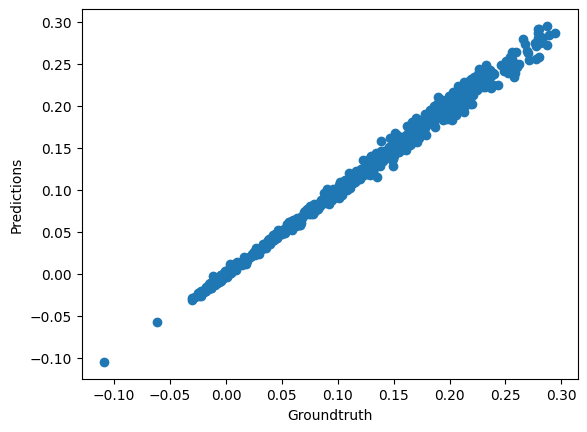

In [17]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [18]:
#%store model_fr_com_x

In [19]:
#for idx, prediction in enumerate(predictions):
#    print(f'Command: {X_test[idx, :3]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [20]:
# Save model
#joblib.dump(model_fr_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fr_com_x.sav")

## Predict CoM -> y

### Linear Regression

In [18]:
# Input
X = np.hstack((X_motion_CoM_acceleration_FR_RL[:, 0:1], # previous motion command
               X_motion_CoM_acceleration_FR_RL[:, 3:4], # current motion command
               X_motion_CoM_acceleration_FR_RL[:, -5:-4], # previous CoM velocity
               X_motion_CoM_acceleration_FR_RL[:, 10:12], # FL (x,y) position
               X_motion_CoM_acceleration_FR_RL[:, 13:15], # FR (x,y) position
               X_motion_CoM_acceleration_FR_RL[:, 16:18], # RL (x,y) position
               X_motion_CoM_acceleration_FR_RL[:, 19:21])) # RR (x,y) position

# Labels
Y = np.array([Y_motion_CoM_acceleration_FR_RL[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fr_com_y = find_best_model(X, Y, runs=5000)

R2:  0.5194581603028704
RMSE:  0.0032952536666861817
The lowest error is:  4.3746117490556236e-06
The highest error is:  0.011028634911047566
The avg. error is:  0.0025057915851828235


In [19]:
model_fr_com_y.coef_

array([[-0.00466095,  0.01108113, -0.01650641, -0.02324012,  0.09919202,
        -0.11070167, -0.3723408 ,  0.09222761, -0.34134963,  0.12420466,
         0.21539615]])

In [20]:
model_fr_com_y.intercept_

array([0.09898882])

Text(0, 0.5, 'Predictions')

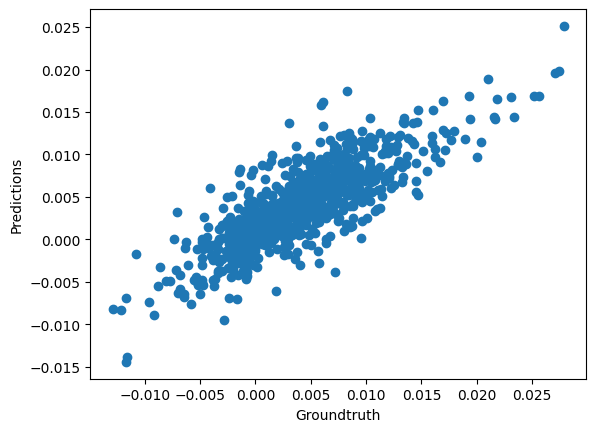

In [21]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [37]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')